- This notebook search images for you based on your input text prompt using [CLIP](https://github.com/openai/CLIP)
- By [Levin Dabhi](https://levindabhi.github.io/)

# Mounting Google drive to where you need to put photos in zip file

- Its okay to have photos in various subfolder or subfolder's subfolder or so on 


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


- Change your zip file path in below cell

In [ ]:
!mkdir images
!unzip /content/gdrive/MyDrive/zipfiles/A1-subset.zip -d /content/images

from pathlib import Path
image_list = list(Path('/content/images').rglob("*.[pPjJ][nNpP][gG]"))

In [ ]:
print('Total images: {}'.format(len(image_list)))

from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image

# dependencies 

In [ ]:
!pip install ftfy==5.8

# Clone to code from the CLIP repository
!git clone https://github.com/openai/CLIP.git
!mkdir clip

# Move the Python files and the vocabulary archive
!mv CLIP/clip/*.py clip/
!mv CLIP/clip/*.gz clip/

import clip
import torch


# Load the open CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

input_resolution = model.input_resolution.item()
context_length = model.context_length.item()
vocab_size = model.vocab_size.item()

preprocess = Compose([
    Resize(input_resolution, interpolation=Image.BICUBIC),
    CenterCrop(input_resolution),
    ToTensor()
])

image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).cuda()
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).cuda()

# Encoding image into features
- This will take time depending on number of Images you have

In [7]:
'========================== Image section ==================================='

'------------ Batchwise -----------'

batch_size = 16
count = 0

img_temp = preprocess(Image.open(image_list[count]).convert('RGB'))
imgs = torch.unsqueeze(img_temp, 0)
count += 1

first_time = True
# del image_features

while count < len(image_list):

    if count % batch_size == 0:
        imgs = imgs.cuda()
        imgs -= image_mean[:, None, None]
        imgs /= image_std[:, None, None]
        with torch.no_grad():
            if first_time:
                image_features = model.encode_image(imgs).float().cpu()
                first_time = False 
            else:
                image_features = torch.cat((image_features, model.encode_image(imgs).float().cpu()), 0) 

        del imgs
        img_temp = preprocess(Image.open(image_list[count]).convert('RGB'))
        imgs = torch.unsqueeze(img_temp, 0)
        count += 1
    
    img_temp = preprocess(Image.open(image_list[count]).convert('RGB'))
    imgs = torch.cat((imgs, torch.unsqueeze(img_temp, 0)), 0)
    del img_temp
    count += 1

imgs = imgs.cuda()
imgs -= image_mean[:, None, None]
imgs /= image_std[:, None, None]
with torch.no_grad():
    if first_time:
        image_features = model.encode_image(imgs).float().cpu()
        first_time = False 
    else:
        image_features = torch.cat((image_features, model.encode_image(imgs).float().cpu()), 0)

image_features /= image_features.norm(dim=-1, keepdim=True)

- Make sure everything is working fine and 1st dim of below output is same as your number of images

In [8]:
print(image_features.shape)

torch.Size([10, 512])


# Encoding text query and putting all togther

In [10]:
def encode_search_query(text_to_search):
    text_to_search = "This is " + text_to_search
    with torch.no_grad():
        # Encode and normalize the search query using CLIP
        text_encoded = model.encode_text(clip.tokenize(text_to_search).to(device))
        text_encoded /= text_encoded.norm(dim=-1, keepdim=True)

    # Retrieve the feature vector from the GPU and convert it to a numpy array
    return text_encoded.cpu().numpy()

In [13]:
def find_photos(text_to_search, topK=3, image_features=image_features):
    import numpy as np
    text_features = encode_search_query(text_to_search)
    similarities = (image_features.numpy() @ text_features.T).squeeze(1)
    
    best_photo_idx = np.argsort(similarities)

    return best_photo_idx[:topK]

# Now comes the main part
- Please change below prompt based on what type of image you want to find
- topK argument represent how many images you want  

In [14]:
rank_list = find_photos("a photo of yummy food", topK=2)

# Display outputs

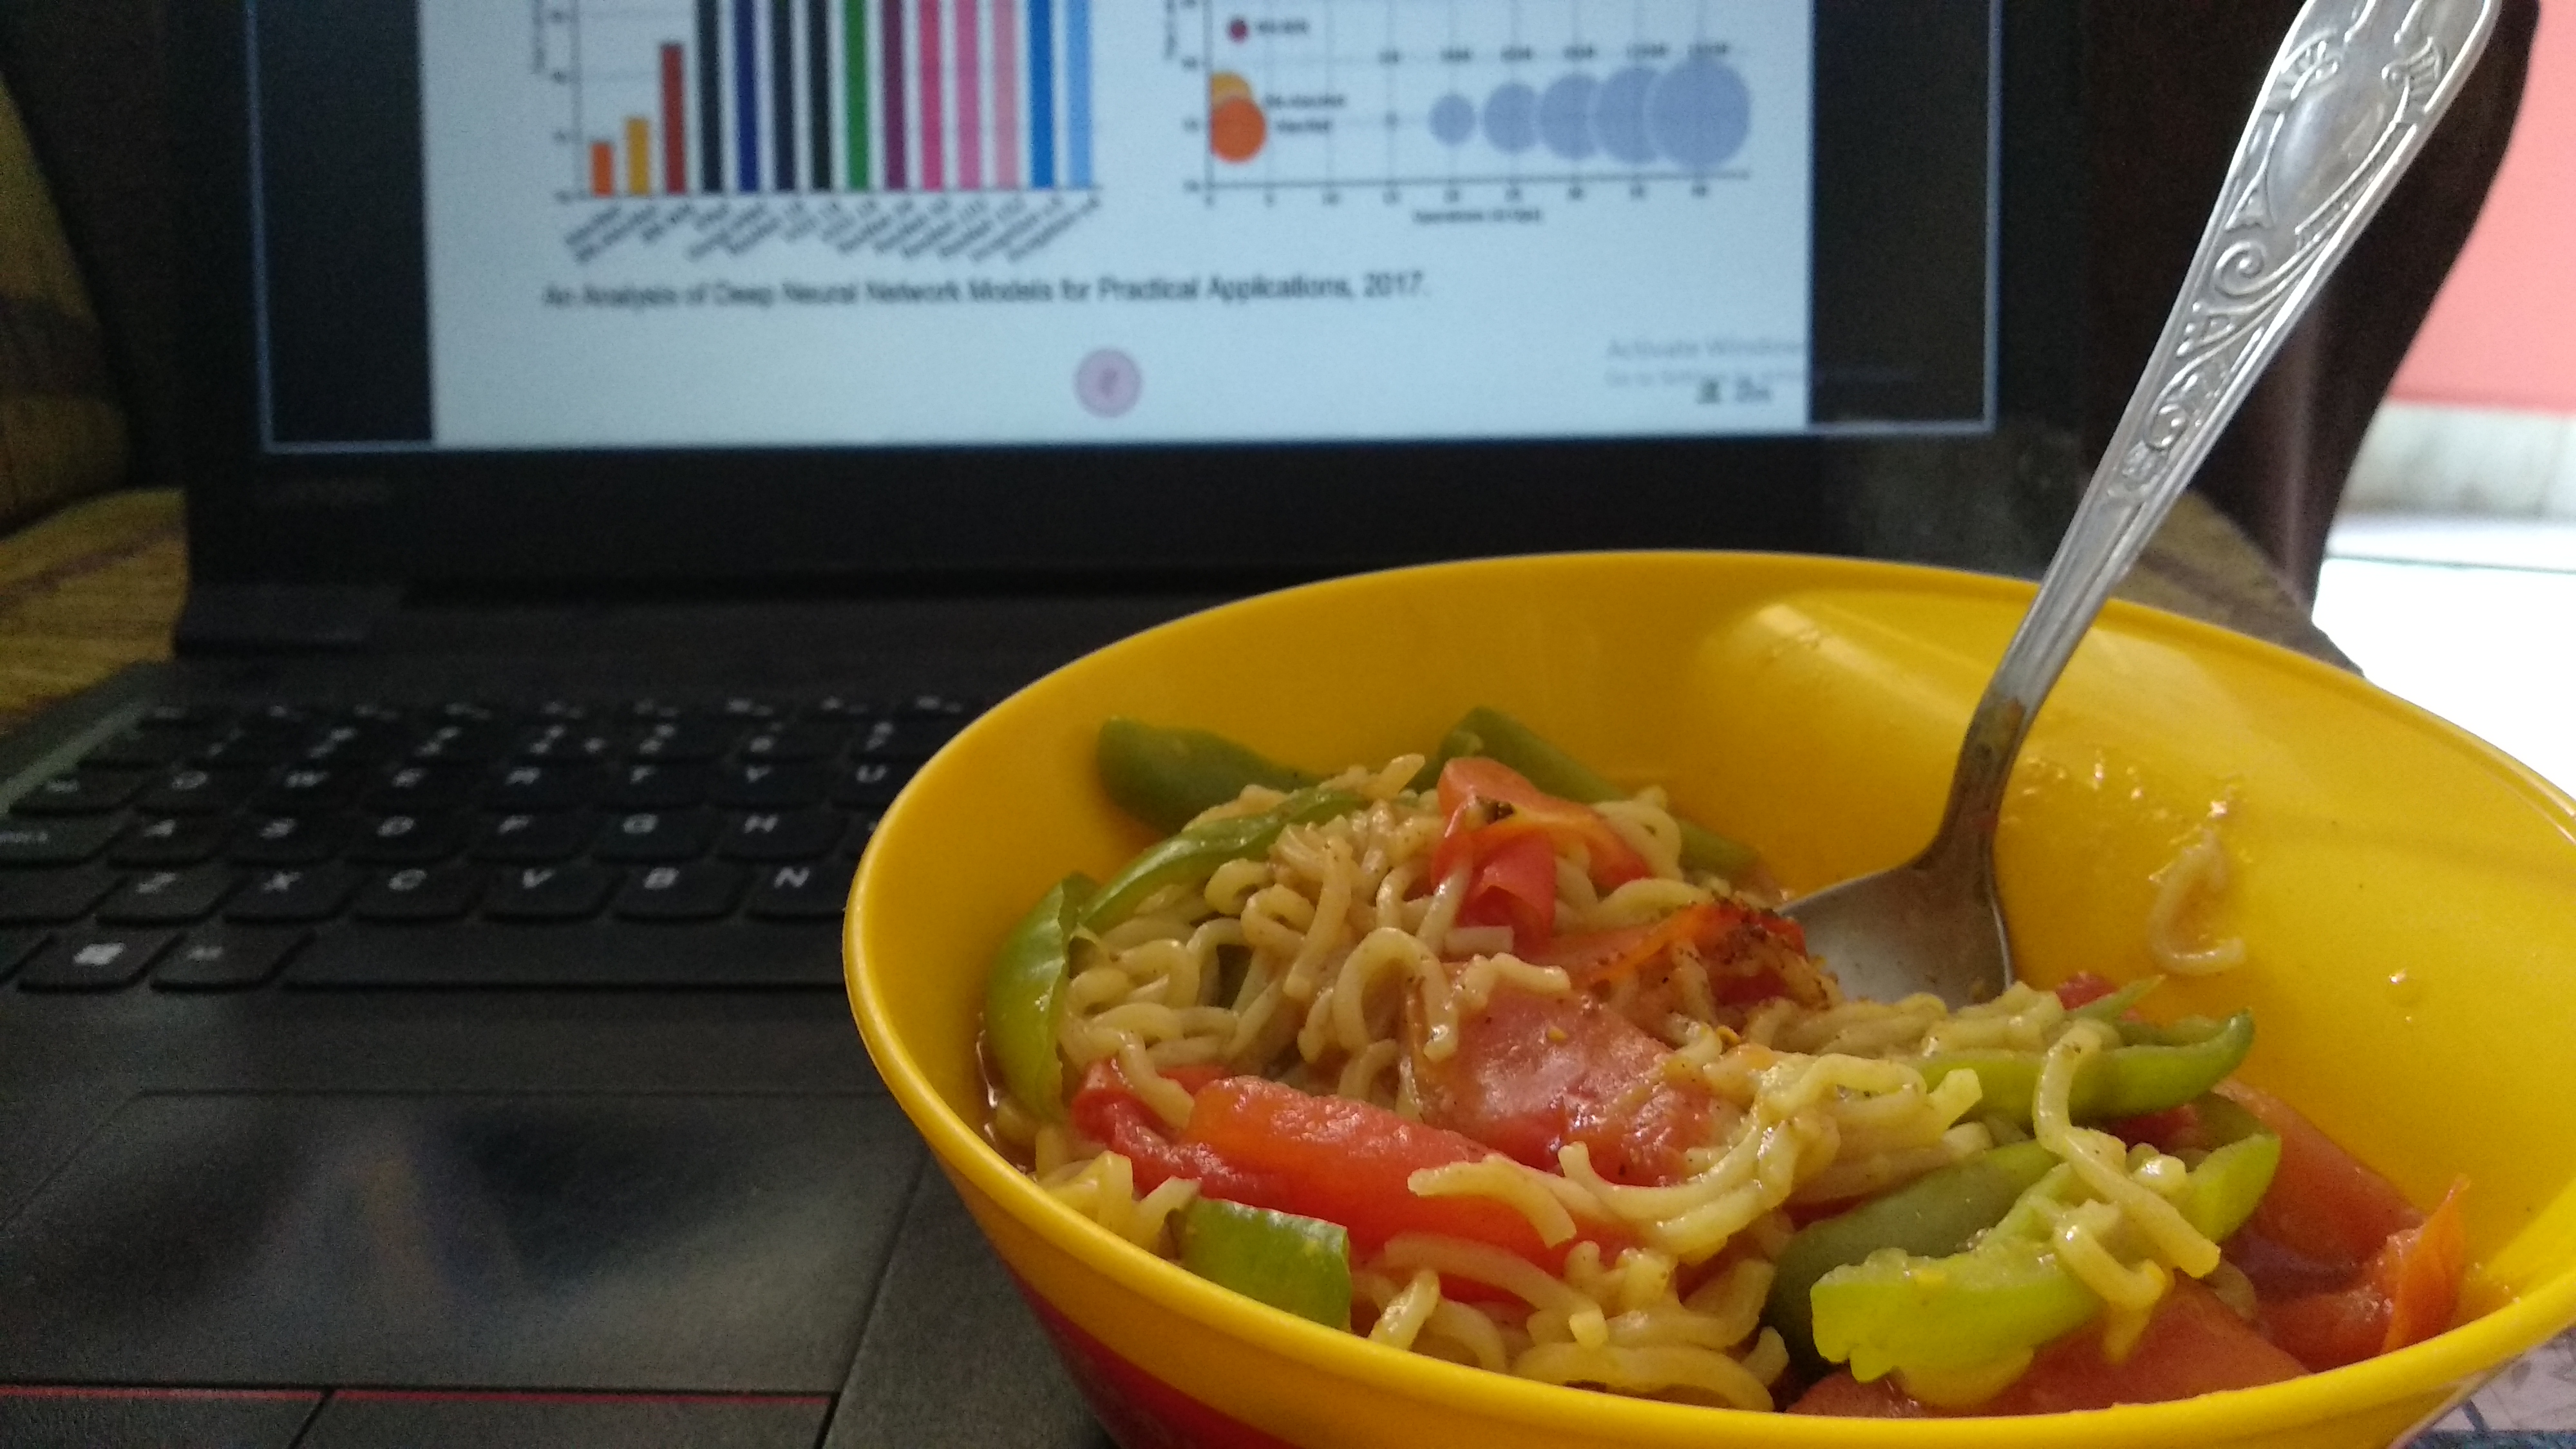

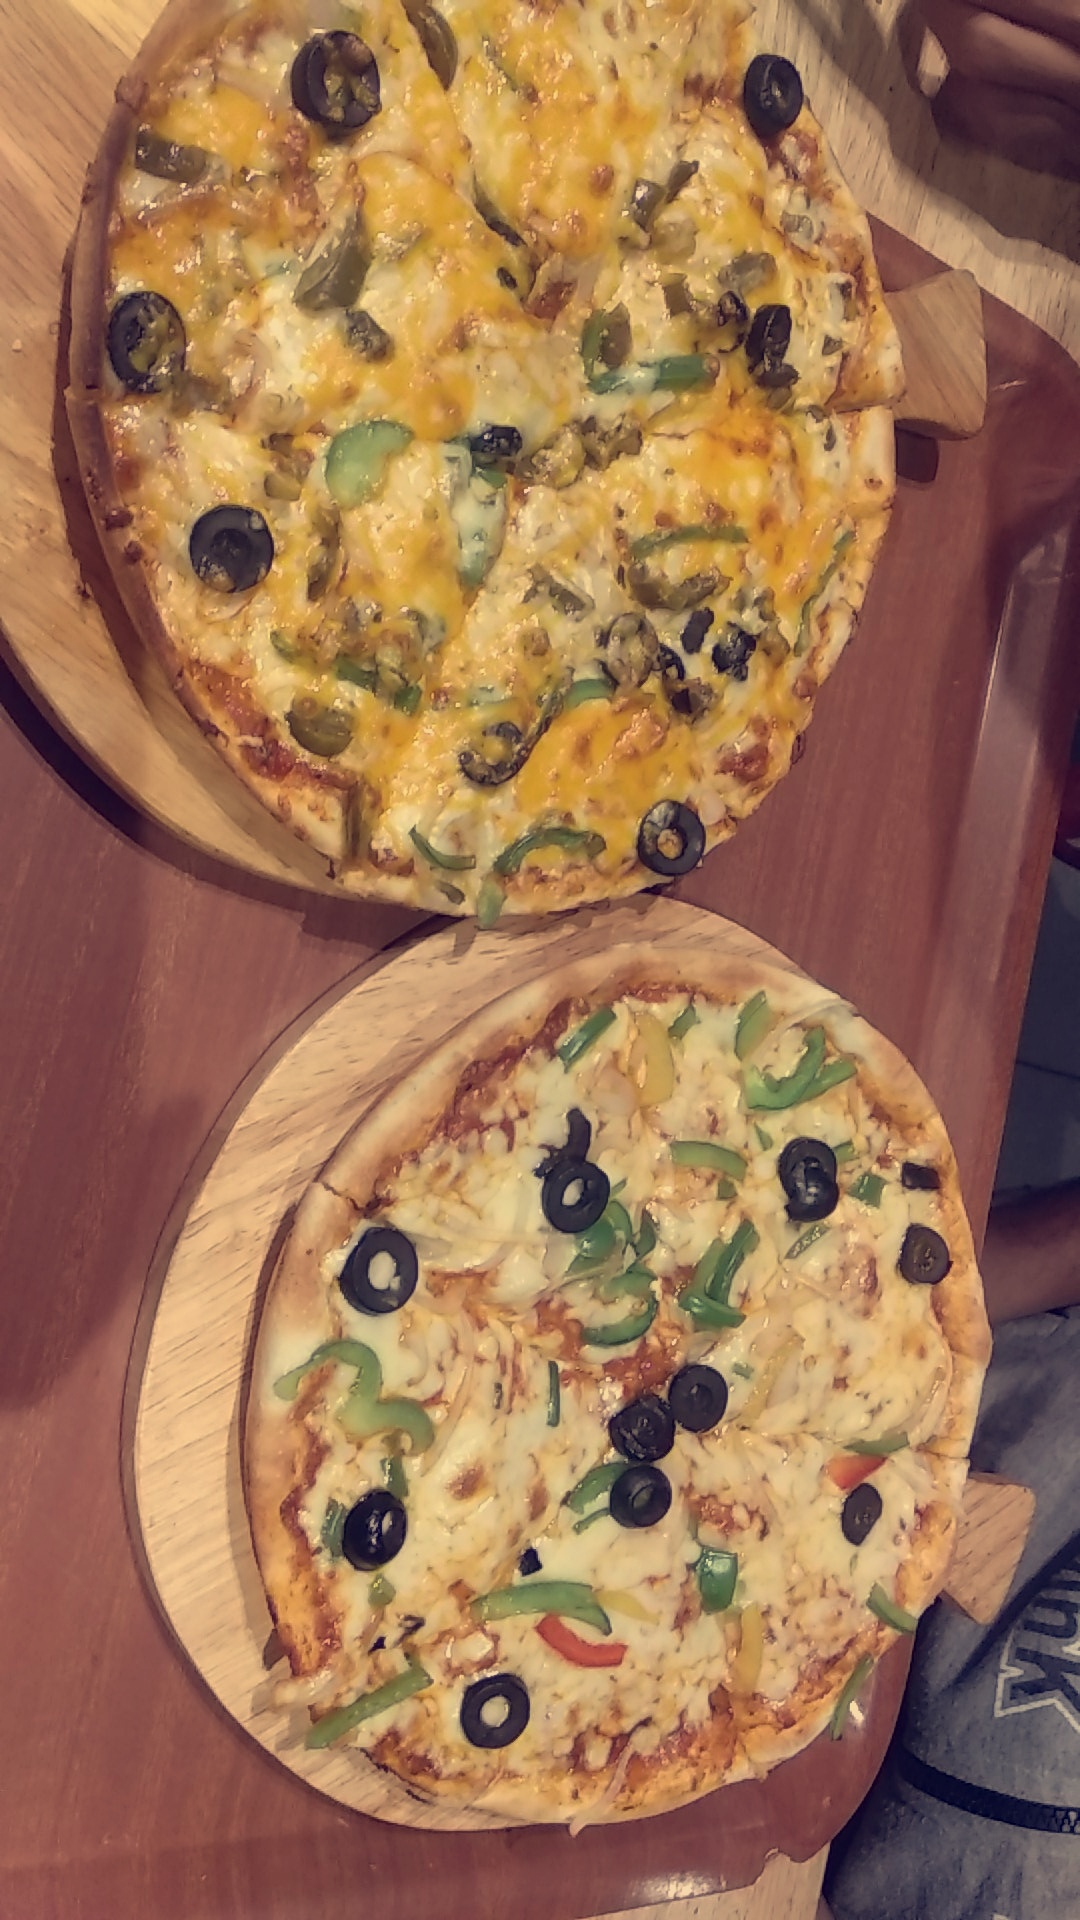

In [15]:
from IPython.display import Image as disp_image
from IPython.display import display

for i in rank_list:
    display(disp_image(str(image_list[i])))